1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats

In [2]:
def f(params):
    x, y = params
    return (4 - 2.1*(x**2) + (x**4)/3) * (x**2) + x * y +((4*(y**2)) - 4) * (y**2)

      fun: -1.0316284534896594
 hess_inv: array([[ 0.12675633, -0.00599026],
       [-0.00599026,  0.06008279]])
      jac: array([-1.19209290e-06,  1.92224979e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([ 0.08984184, -0.71265628])


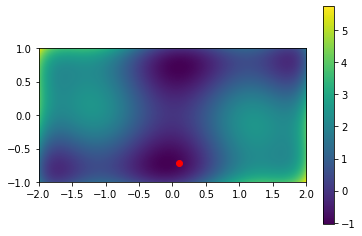

In [4]:
x = np.linspace(-2,2,1000)
y = np.linspace(-1,1,1000)

X,Y = np.meshgrid(x,y)
params = (X,Y)
Z = f(params)
solution = scipy.optimize.minimize(f,[-2,-1])
print(solution)

im = plt.imshow(Z,extent=[-2, 2, -1, 1])
plt.colorbar(im)
plt.scatter(solution.x[0],solution.x[1],c='r')
plt.show()

In [5]:
out = np.where(Z == np.amin(Z))
print('Number of global minima: ',str(len(out[0])))
print('Function value at these points: ',str(Z[out][0]))

Number of global minima:  2
Function value at these points:  -1.0316206805316686


In [7]:
solution = scipy.optimize.minimize(f,[0,0])
print(solution)
# putting inside the minimization function an initial guess (x=0,y=0) cause a wrong calculation of minima

      fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

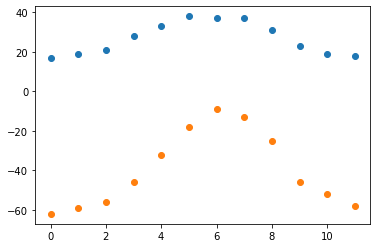

In [8]:
max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
x = np.arange(0,12)

plt.scatter(x,max)
plt.scatter(x,min)
plt.show()

In [9]:
def gauss(x,c,w,h,o):
    return (np.exp(-((((x-c)/w)**2)/2))*h)+o

[ 5.73581602 -2.29443411 23.09208045 15.77932971]
[  0.72583725  -1.52016601 -31.78580713 -31.64951933]


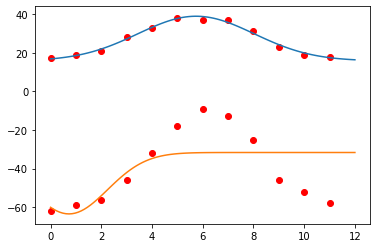

In [11]:
x2= np.arange(12)
params_max,_ = scipy.optimize.curve_fit(gauss,x2,max)
params_min,_ = scipy.optimize.curve_fit(gauss,x2,min)
print(params_max)
print(params_min)

x = np.linspace(0,12,100)
y_max = gauss(x,params_max[0],params_max[1],params_max[2],params_max[3])
y_min = gauss(x,params_min[0],params_min[1],params_min[2],params_min[3])

plt.plot(x,y_max)
plt.plot(x,y_min)
plt.scatter(x2,max,c='r')
plt.scatter(x2,min,c='r')
plt.show()

# if we don't specify an initial time offset different than 1, curve_fit doesn't work well. 

[ 5.73581562 -2.29443192 23.0920725  15.77934323]
[  6.16452603  -1.97590002  52.64929159 -61.32093489]


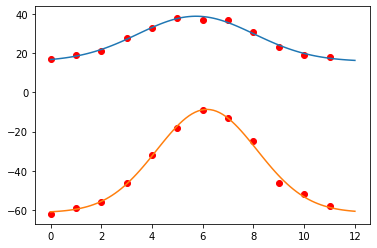

In [14]:
x2= np.arange(12)
params_max,_ = scipy.optimize.curve_fit(gauss,x2,max,p0=(6,1,1,1))
params_min,_ = scipy.optimize.curve_fit(gauss,x2,min,p0=(6,1,1,1))
print(params_max)
print(params_min)

x = np.linspace(0,12,100)
y_max = gauss(x,params_max[0],params_max[1],params_max[2],params_max[3])
y_min = gauss(x,params_min[0],params_min[1],params_min[2],params_min[3])

plt.plot(x,y_max)
plt.plot(x,y_min)
plt.scatter(x2,max,c='r')
plt.scatter(x2,min,c='r')
plt.show()
# so in this case, specifying, the fit is reasonable

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [ ]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

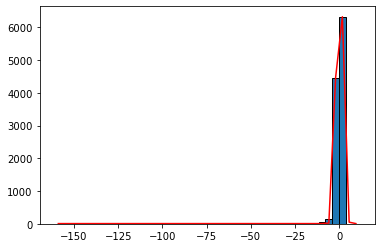

In [97]:
import pickle
infile = open('./data/residuals_261.pkl', 'rb')
new_dict = pickle.load(infile)
infile.close()

df = pd.DataFrame(new_dict.tolist())
y,bin_edges,_=plt.hist(df['residuals'].values,bins='rice', edgecolor = "black")
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.

params,_ = scipy.optimize.curve_fit(gauss,bin_centres,y)

y_fit = gauss(bin_centres,params[0],params[1],params[2],params[3])

plt.plot(bin_centres,y_fit,c='r')
plt.show()

In [98]:
err = 1/np.sqrt(y)

<ipython-input-98-263f847d72d2>:1: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(y)


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [ ]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/

In [110]:
df = pd.read_csv('./data/munich_temperatures_average_with_bad_data.txt',sep=' ',names=['Day','Temp'])
df

,Day,Temp
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


In [131]:
from math import pi
def f(t,a,b,c):
    return a*np.cos(2*pi*t + b) + c

In [132]:
def g(t,a,b,c,d):
    return a*np.cos(2*pi*b*t + c) + d

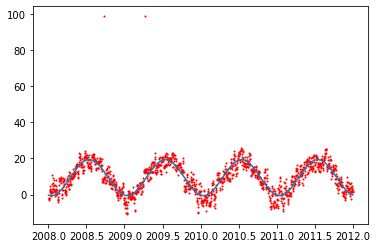

Best-fit parameters:  [-9.98813369 12.33302301  9.38411486]
Average temperature in Munich 9.384097734976043
Hottest typical day temperature predicted:  19.372248549477835
Coldest typical day temperature predicted:  -0.6040188247209599


In [152]:
range_x=df[(df['Day']>=2008)&(df['Day']<=2012)]['Day']
range_y=df[(df['Day']>=2008)&(df['Day']<=2012)]['Temp']
params,_ = scipy.optimize.curve_fit(f,range_x,range_y)

f_fit = f(range_x,params[0],params[1],params[2])
plt.plot(range_x,f_fit)
plt.scatter(range_x,range_y,s=1,c='r')
plt.show()

print("Best-fit parameters: ",str(params))
print("Average temperature in Munich",str(np.average(range_y)))
print("Hottest typical day temperature predicted: ",str(abs(params[0])+params[2]))
print("Coldest typical day temperature predicted: ",str(params[0]+params[2]))

# b parameter represents the phase in a sinusoidal function. The physical sense is to move the function in the right or in the left

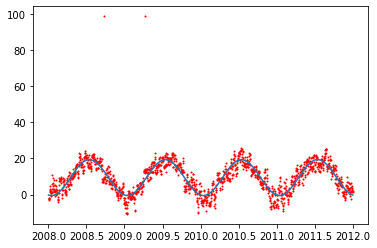

Best-fit parameters:  [-9.98218297  1.00144407 -5.90482268  9.39812499]


In [134]:
params,_ = scipy.optimize.curve_fit(g,range_x,range_y)

g_fit = g(range_x,params[0],params[1],params[2],params[3])
plt.plot(range_x,g_fit)
plt.scatter(range_x,range_y,s=1,c='r')
plt.show()

print("Best-fit parameters: ",str(params))

In [141]:
RSS_1=np.sum(np.square(range_y - f_fit))
print("RSS 1: ",str(RSS_1))

RSS_2=np.sum(np.square(range_y - g_fit))
print("RSS 2: ",str(RSS_2))

RSS 1:  34359.85859996652
RSS 2:  34352.79405370932


In [146]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - scipy.stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

ndof_1 = 2
ndof_2 = 3 

cl=Ftest(RSS_1,RSS_2,ndof_1,ndof_2,len(range_y),verbose=True)

CL: 0.584 , additional parameter necessary: NO
